# Импорт необходимых библиотек

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn import metrics

# Загрузка данных

In [2]:
data = data = pd.read_excel('data/data_ford_price.xlsx')
data.head(3) 

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0


# Поиск пропусков 

In [3]:
data.isnull().sum()

price              0
year               0
condition          0
cylinders          0
odometer           0
title_status       0
transmission       0
drive            391
size            1564
lat                0
long               0
weather          180
dtype: int64

# Поиск наиболее популярных значений для обработки пропусков в категориальных признаках, а также поиск среднего значения для обработки пропусков в числовом признаке

In [4]:
drive = data['drive'].value_counts() 
size = data['size'].value_counts() 
weather = data['weather'].mean().round(0)
display(drive, size, weather)

drive
4wd    4888
rwd    1653
fwd      85
Name: count, dtype: int64

size
full-size      4570
mid-size        867
compact          15
sub-compact       1
Name: count, dtype: int64

52.0

# Обработка пропусков

In [5]:
data['weather'] = data['weather'].fillna(np.round(np.mean(data['weather']),0))
data['size'] = data['size'].fillna('full-size')
data['drive'] = data['drive'].fillna('4wd')
data.isnull().sum()

price           0
year            0
condition       0
cylinders       0
odometer        0
title_status    0
transmission    0
drive           0
size            0
lat             0
long            0
weather         0
dtype: int64

# Построение мтрицы корреляции

<Axes: >

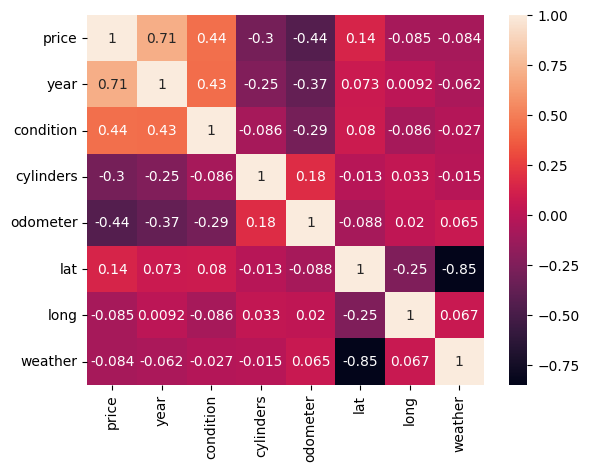

In [6]:
sns.heatmap(data.corr(numeric_only=True), annot=True)

# Удаление признака с высокой корреляцией

In [13]:
data = data.drop(columns='lat',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         7017 non-null   object 
 8   size          7017 non-null   object 
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 603.1+ KB


# Кодирование признаков

In [14]:
columns_to_encoding = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
one_hot_encoder = OneHotEncoder()
data_encoding = one_hot_encoder.fit_transform(data[columns_to_encoding]).toarray()
columns_names = one_hot_encoder.get_feature_names_out(columns_to_encoding)
data_encoding = pd.DataFrame(data_encoding, index=data.index, columns=columns_names)
data = pd.concat([data, data_encoding], axis=1) 
data = data.drop(columns=columns_to_encoding)
data.head(3)

,price,year,condition,odometer,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,43900,2016,4,43500,-82.483400,59.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,15490,2009,2,98131,-74.281734,52.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2495,2002,2,201803,-82.949564,45.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Создание тренировочной и тестовой выборок для обучения модели

In [15]:
x = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Метод рекурсивного исключения признаков

In [16]:
estimator = LinearRegression()
selecter = RFE(estimator, n_features_to_select=3, step=1)
selecter.fit(X_train, y_train)
selecter.get_feature_names_out()

array(['size_compact', 'size_full-size', 'size_sub-compact'], dtype=object)

# Метод отбора признаков на основе фильтров

In [19]:
selecter_2 = SelectKBest(f_regression, k=3)
selecter_2.fit(X_train, y_train)
selecter_2.get_feature_names_out()

array(['year', 'condition', 'odometer'], dtype=object)

# Разбиение данных на тренировочную и тестовую выборки согласно результату работы метода рекурсивного исключения признаков

In [24]:
x_rfe = data[['size_compact', 'size_full-size', 'size_sub-compact']]
y_rfe = data['price']

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(x_rfe, y_rfe, test_size=0.2, random_state=42)

# Обучение модели на признаках метода рекурсивного исключения признаков

In [35]:
model = LinearRegression()
model.fit(X_train_rfe, y_train_rfe)
y_pred_rfe = model.predict(X_test_rfe)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test_rfe, y_pred_rfe)))

R^2 score: 0.04


# Разбиение данных на тренировочную и тестовую выборки согласно результату работы метода отбора признаков на основе фильтров

In [26]:
x_skb = data[['year', 'condition', 'odometer']]
y_skb = data['price']

X_train_skb, X_test_skb, y_train_skb, y_test_skb = train_test_split(x_skb, y_skb, test_size=0.2, random_state=42)

# Обучение модели на признаках метода отбора признаков на основе фильтров

In [34]:
model_2 = LinearRegression()
model_2.fit(X_train_skb, y_train_skb)
y_pred_skb = model_2.predict(X_test_skb)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test_skb, y_pred_skb)))

R^2 score: 0.42


# Обучение модели на основе всех признкаов

In [33]:
model_3 = LinearRegression()
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test, y_pred)))

R^2 score: 0.42


##### Согласно результату обучения всех моделей на разном количестве признаков, наихудшим методом отбора признаков оказался метод рекурсивного исключения, поскольку показывает наихудший результат работы модели - 0.04. Метод отбора признаков на основе фильтров показал себя гораздо лучше, поскольку увеличил качество модели на 0.38 пунктов(90.48%), однако, как и в предыдущем случае модель является недообученной. При обучении модели на всех признаках, модель, так же как и в случае обучения на признаках, отобранных методом на основе фильтров, показывает неудовлетворительный результат (R 2 score: 0.42), что в свою очередь также говорит о недообученности модели. Предполагаю плохое качество модели можно исправить применив стандартизацию к данным.       

In [42]:
from sklearn.preprocessing import StandardScaler

data_scaled = data.copy()
col_names = data.columns
x = data_scaled[col_names]

scaler = StandardScaler()
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled.head(3) 

,price,year,condition,odometer,long,weather,cylinders_3,cylinders_4,cylinders_5,cylinders_6,...,transmission_automatic,transmission_manual,transmission_other,drive_4wd,drive_fwd,drive_rwd,size_compact,size_full-size,size_mid-size,size_sub-compact
0,2.446193,1.165656,1.991596,-0.850559,0.671433,0.873805,-0.011939,-0.039624,-0.026703,1.493043,...,0.214626,-0.201963,-0.069778,0.573785,-0.110734,-0.555127,-0.046284,0.37941,-0.375467,-0.011939
1,0.031319,0.162048,-0.850879,-0.242979,1.256025,-0.017733,-0.011939,-0.039624,-0.026703,-0.669773,...,0.214626,-0.201963,-0.069778,0.573785,-0.110734,-0.555127,-0.046284,0.37941,-0.375467,-0.011939
2,-1.073268,-0.841561,-0.850879,0.910011,0.638206,-0.909272,-0.011939,-0.039624,-0.026703,-0.669773,...,0.214626,-0.201963,-0.069778,0.573785,-0.110734,-0.555127,-0.046284,0.37941,-0.375467,-0.011939


In [43]:
x = data_scaled.drop('price', axis=1)
y = data_scaled['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [44]:
estimator = LinearRegression()
selecter = RFE(estimator, n_features_to_select=3, step=1)
selecter.fit(X_train, y_train)
selecter.get_feature_names_out()

array(['drive_4wd', 'drive_fwd', 'drive_rwd'], dtype=object)

In [49]:
x_rfe = data_scaled[['drive_4wd', 'drive_fwd', 'drive_rwd']]
y_rfe = data_scaled['price']

X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(x_rfe, y_rfe, test_size=0.2, random_state=42)

model_4 = LinearRegression()
model_4.fit(X_train_rfe, y_train_rfe)
y_pred_rfe = model_4.predict(X_test_rfe)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test_rfe, y_pred_rfe)))

R^2 score: 0.07


In [45]:
selecter = SelectKBest(f_regression, k=3)
selecter.fit(X_train, y_train)
selecter.get_feature_names_out()

array(['year', 'condition', 'odometer'], dtype=object)

In [50]:
x_skb = data_scaled[['year', 'condition', 'odometer']]
y_skb = data_scaled['price']

X_train_skb, X_test_skb, y_train_skb, y_test_skb = train_test_split(x_skb, y_skb, test_size=0.2, random_state=42)

model_5 = LinearRegression()
model_5.fit(X_train_skb, y_train_skb)
y_pred_skb = model_5.predict(X_test_skb)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test_skb, y_pred_skb)))

R^2 score: 0.42


In [51]:
model_6 = LinearRegression()
model_6.fit(X_train, y_train)
y_pred = model_6.predict(X_test)
print('R^2 score: {:.2f}'.format(metrics.r2_score(y_test, y_pred)))

R^2 score: 0.46


##### После проведения стандартизации данных и повторном обучении моделей на описанных ранее методах выбора признаков и на всех данных, качество моделей изменялось следующим образом:
* Модель по методу RFE - R 2 score: 0.07. Результат, по сравнению с предыдущим, увеличился на 0.03 пункта, однако это по прежнему наихудшая из всех моделей;
* Модель по методу на основе фильтрации - R 2 score: 0.42. Результат, по сравнению с предыдущим, не изменился;
* Модель обученная на всех данных - R 2 score: 0.46. Результат, по сравнению с предыдущим изменился на 0.02 пункта.

К сожалению все модели по прежнему имеют неудовлетворительное качество. Предполагаю, что для достижения удовлетворительного результата обучения нужно воспользоваться более сложными моделями, например, градиентный спуск.